In [29]:
import sys
import numpy as np
import random
import winsound
import matplotlib.pyplot as plt
from electron_rigol_class import *
from electron_RS_class import *
import os
try:
    import TimeTagger
except:
    print ("Time Tagger lib is not in the search path.")
    pyversion = sys.version_info
    from winreg import ConnectRegistry, OpenKey, HKEY_LOCAL_MACHINE, QueryValueEx
    registry_path = "SOFTWARE\\Python\\PythonCore\\" + str(pyversion.major) + "." + str(pyversion.minor) + "\\PythonPath\\Time Tagger"
    reg = ConnectRegistry(None, HKEY_LOCAL_MACHINE)
    key = OpenKey(reg, registry_path) 
    module_path = QueryValueEx(key,'')[0]
    print ("adding " + module_path)
    sys.path.append(module_path)
    
from TimeTagger import createTimeTagger, Counter, Countrate, Histogram, LOW, HIGH, freeTimeTagger, scanTimeTagger, ConstantFractionDiscriminator
from time import sleep
from pylab import *
from pathlib import Path



save_date = '2020_05_28'
date = '20200528'

data_folder = r'C:\Users\cm467\Documents\Jupyter'
save_folder = data_folder + '/' + save_date + '/' + 'trapfrequency'

if os.path.exists(save_folder) == False:
    Path(save_folder).mkdir(parents=True, exist_ok=False)
    os.chdir(save_folder)
else:
    os.chdir(save_folder)

roi = []
variable = []

# print (scanTimeTagger())

# create a timetagger instance
tagger = createTimeTagger()
# print (scanTimeTagger())
tagger.reset()
trigger = 0.5
tagger.setTriggerLevel(2, trigger)
tagger.setDeadtime(2, 100000)
# Ch2_CFD = ConstantFractionDiscriminator(tagger,[2], search_window = 10000)
# CFD_channels = Ch2_CFD.getChannels()

# Rigol
sampling_time = 200.E-9
rigol =  rigol(sampling_time)

# R&S
rs = RS()


###############################
# Set up experiment: variable parameters
###############################
U2 = -0.7
Prf = +2.5
Ex = -0.01
Ey = 0.0
Ez=-0.15
U1=0.2
# parameters for the Rigol waveforms
# trap frequency stuff:
# freq_trapfreq = 1E5 # parameters for trap freq. measurement
frequencies = np.arange(66, 77, 0.1) * 1E6
amp_trapfreq = -20.0

pulse_width_ao = 200 * 1.E-6
# pulse_width_loading = np.arange(10, 210, 10) * 1.E-6
wait_time = 4000.E-6


pulse_delay_ao = sampling_time
pulse_width_ej = 20.E-9
pulse_delay_ej = 2.E-9 

exp_cycles = 5E2  # how many experiment repetitions
################################
# for pulse_width_ao in pulse_width_loading:
# for wait_time in wait_times:
cycle_duration,wait_time_corr = rigol.run(pulse_width_ao, pulse_delay_ao, pulse_width_ej, pulse_delay_ej, wait_time)
for freq_trapfreq in frequencies:
    # program and switch on Rigol, returns repetition period in s
#     cycle_duration,wait_time_corr = rigol.run(pulse_width_ao, pulse_delay_ao, pulse_width_ej, pulse_delay_ej, wait_time)
    rs.run(freq_trapfreq,amp_trapfreq)
#     print (cycle_duration)
#     filename = '20200312_lifetime_U2_' + str("{:.2f}".format(U2)) +'_Ex' + str("{:.2f}".format(Ex)) + '_Prf' + str("{:.2f}".format(Prf)) +'dBm_Tload' + str("{:n}".format(pulse_width_ao/1E-6)) + 'us_Tej' \
#     + str("{:n}".format(pulse_width_ej/1E-9)) + 'ns_wait' + str("{:n}".format(wait_time_corr/1E-6)) + 'us_reps'+ \
#     str("{:.1e}".format(exp_cycles)) +'_trigger' + str("{:.1f}".format(trigger))+ 'new_board.txt'
#     print (filename)
    ###############################
    # set up time tagger histogram and take data
    bwidth = 500
#     print (cycle_duration/binwidth*1E12 - 100)
    n_bin = int(500*(1000/bwidth))
    histo = Histogram(tagger, click_channel = 2, start_channel = 1, binwidth = bwidth, n_bins = n_bin)
    tagger.sync()
    histo.clear()
#     print (cycle_duration * exp_cycles)
    sleep(cycle_duration * exp_cycles)
    data = histo.getData()
    
    ###############################
    roi_start = int(80 * 1000/bwidth)
    roi_stop = int(130 *1000/bwidth)
    # save data
    x_data = np.arange(0, n_bin) * bwidth/1000
    file_data = np.array([x_data[0:1000], data[0:1000]])
#     file_data = np.array([x_data, data])
    file_data = file_data.T
#     print (file_data)
#     np.savetxt(filename, file_data, delimiter=',')
#     print (wait_time*1E3, np.sum(data[roi_start:roi_stop]))
    print (freq_trapfreq/1E6, np.sum(data[roi_start:roi_stop]))
#     print (pulse_width_ao, np.sum(data[roi_start:roi_stop]))
    roi = np.append(roi, np.sum(data[roi_start:roi_stop]))
    variable = np.append(variable, freq_trapfreq)
#     variable = np.append(variable, wait_time)
#     variable = np.append(variable, pulse_width_ao)


filename_roi = date + '_trap-frequency_ROI_U2_' + str("{:.2f}".format(U2)) +'_U1_' + str("{:.2f}".format(U1))+'_Ex' + str("{:.2f}".format(Ex)) +'_Ez' + str("{:.2f}".format(Ez))+'_Prf' + str("{:.2f}".format(Prf)) +'dBm_Tej' \
    + str("{:n}".format(pulse_width_ej/1E-9)) + 'ns_wait' + str("{:n}".format(wait_time_corr/1E-6)) + 'us_Tload' + str("{:n}".format(pulse_width_ao/1E-6)) + 'us_tickle' + str("{:n}".format(amp_trapfreq)) + 'dBm_reps'+ \
    str("{:.1e}".format(exp_cycles)) + '_trigger' + str("{:.1f}".format(trigger))+'_+300V.txt'




ROI_data = np.array([variable,roi])
ROI_data = ROI_data.T 
np.savetxt(filename_roi,ROI_data,delimiter=',')

rs.stop()

frequency = 440  # Set Frequency To 2500 Hertz
duration = 1000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)


Rohde&Schwarz,SMB100A,1406.6000k02/104542,3.0.13.0-2.20.382.35
66.0 204
66.1 176
66.19999999999999 188
66.29999999999998 215
66.39999999999998 199
66.49999999999997 202
66.59999999999997 201
66.69999999999996 186
66.79999999999995 199
66.89999999999995 183
66.99999999999994 186
67.09999999999994 194
67.19999999999993 188
67.29999999999993 191
67.39999999999992 206
67.49999999999991 199
67.59999999999991 175
67.69999999999992 197
67.7999999999999 204
67.89999999999989 195
67.99999999999989 200
68.09999999999988 184
68.19999999999987 178
68.29999999999987 185
68.39999999999986 191
68.49999999999986 171
68.59999999999985 181
68.69999999999985 183
68.79999999999984 158
68.89999999999984 166
68.99999999999983 193
69.09999999999982 150
69.19999999999982 156
69.29999999999981 153
69.3999999999998 142
69.4999999999998 140
69.5999999999998 124
69.69999999999979 138
69.7999999999998 130
69.89999999999978 133
69.99999999999977 106
70.09999999999977 103
70.19999999999976 102
70.29999999999976 93
7

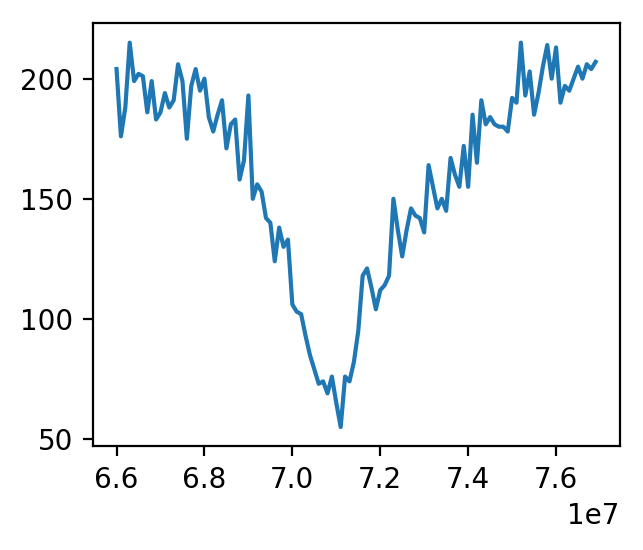

In [30]:
plt.figure(figsize = (3.4,2.8), dpi = 200)
plt.plot(variable,roi, '-')
# plt.semilogy(variable, exp(variable, *popt))
# plt.ylim(0,200)
plt.show()

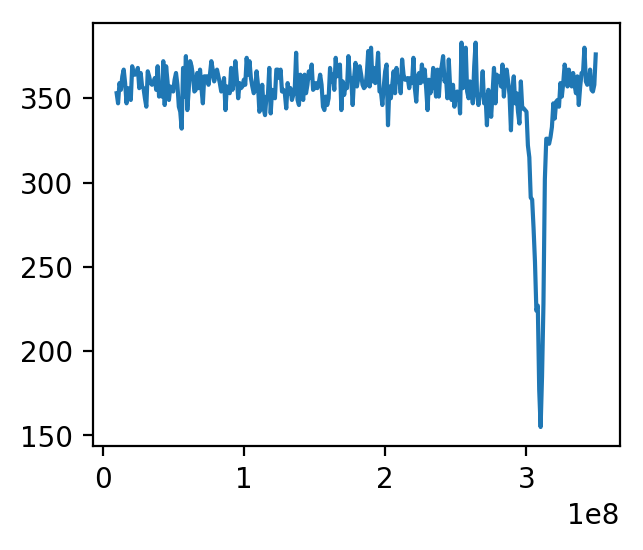

In [14]:
plt.figure(figsize = (3.4,2.8), dpi = 200)
plt.plot(variable,roi, '-')
# plt.semilogy(variable, exp(variable, *popt))
# plt.xlim(40E6,60E6)
plt.show()

[2.15858011e+02 3.92391033e-02]
[1.02315057e+01 6.48579209e-03]


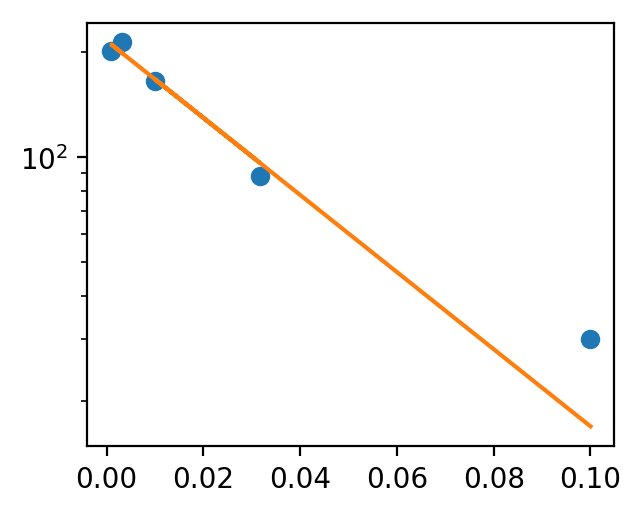

In [56]:
from scipy.optimize import curve_fit
def exp(time, amp, tau):
    return amp * np.exp(-time/tau)

popt, pcov = curve_fit(exp, variable, roi, p0 = [600, 0.04])
fit_errors = np.sqrt(np.diag(pcov))
print (popt)
print (fit_errors)

plt.figure(figsize = (3.4,2.8), dpi = 200)
plt.semilogy(variable,roi, 'o')
plt.semilogy(variable, exp(variable, *popt))
# plt.ylim(0,200)
plt.show()
# scanTimeTagger()
# freeTimeTagger(tagger)
# scanTimeTagger()
# tagger.reset()